## **О наборе данных (About Dataset)**

**Источник:** https://www.kaggle.com/datasets/ludocielbeckett/health-risk-prediction-anonymized-real-data

### **Описание (Description)**

Этот набор данных содержит реальные медицинские данные пациентов, которые были тщательно очищены и анонимизированы для защиты конфиденциальности. Он включает витальные признаки и клинические параметры для 1000 пациентов, а также соответствующие уровни риска для их здоровья (Нормальный, Низкий, Средний, Высокий).

Набор данных предназначен для машинного обучения, анализа данных и исследований в области медицинской аналитики. Его можно использовать для построения прогностических моделей, которые помогают медицинским работникам в раннем выявлении пациентов высокого риска и принятии более обоснованных врачебных решений.

**Столбцы (Columns):**

*   **Patient_ID** – Уникальный анонимизированный идентификатор пациента.
*   **Respiratory_Rate** – Частота дыхания (дыхательных движений в минуту).
*   **Oxygen_Saturation** – Сатурация кислорода, уровень насыщения крови кислородом (%).
*   **O2_Scale** – Используемая шкала кислородной терапии.
*   **Systolic_BP** – Систолическое артериальное давление (мм рт. ст.).
*   **Heart_Rate** – Частота сердечных сокращений (ударов в минуту).
*   **Temperature** – Температура тела (°C).
*   **Consciousness** – Уровень сознания (A = Ясное, P = Реакция на боль, C = Спутанное, V = Реакция на голос, U = Не реагирует).
*   **On_Oxygen** – Пользуется ли пациент дополнительным кислородом (0 = Нет, 1 = Да).
*   **Risk_Level** – Целевая переменная (Нормальный, Низкий, Средний, Высокий).

**Потенциальные области применения (Potential Use Cases):**

*   Разработка моделей машинного обучения для классификации рисков.
*   Выявление наиболее критичных признаков, влияющих на уровень риска пациента.
*   Медицинские симуляции и академические исследовательские проекты.
*   Создание систем поддержки врачебных решений (СППР).

## **Ход работы**

### **Выбор целевого атрибута (метки)**
В данном наборе данных атрибут Risk_Level является целевым классом (меткой), так как:
- Он содержит категориальные значения (Normal, Low, Medium, High), которые представляют собой классификацию уровня риска пациента.
- Остальные атрибуты (такие как Respiratory_Rate, Oxygen_Saturation, Systolic_BP и т.д.) являются признаками (фичами), которые могут влиять на определение уровня риска.

### **Оценка сбалансированности классов**
Для оценки сбалансированности посчитаем количество записей для каждого класса в столбце Risk_Level

In [1]:
import pandas as pd

df = pd.read_csv('Health_Risk_Dataset.csv')

class_distribution = df['Risk_Level'].value_counts()
class_distribution

Risk_Level
Medium    306
High      279
Low       255
Normal    160
Name: count, dtype: int64

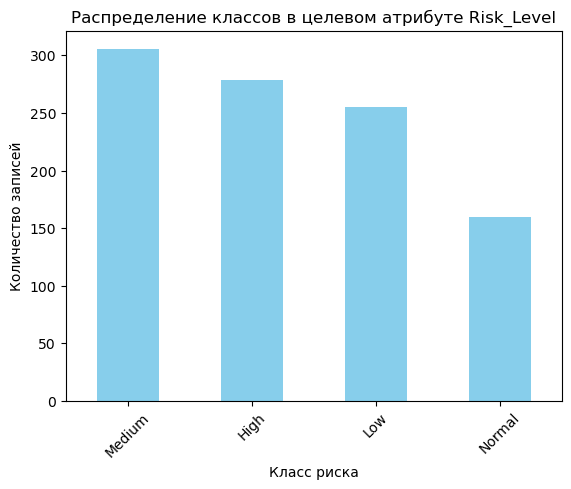

In [2]:
import matplotlib.pyplot as plt

class_distribution.plot(kind='bar', color='skyblue')
plt.title('Распределение классов в целевом атрибуте Risk_Level')
plt.xlabel('Класс риска')
plt.ylabel('Количество записей')
plt.xticks(rotation=45)
plt.show()

### **Классы не сбалансированы**
Класс Normal представлен всего 160 примерами, что почти в 2 раза меньше, чем класс Medium.

Это может привести к тому, что модель будет хуже предсказывать класс Normal из-за его недостаточной представленности, однако дисбаланс не является критическим

### **Сравнение алгоритмов классификации: kNN и дерево решений**

#### **Импорт необходимых библиотек**

In [3]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_curve, auc)
from itertools import cycle

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

#### **Обзор данных**

In [4]:
print("Размерность данных:", df.shape)
df.head()

Размерность данных: (1000, 10)


,Patient_ID,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,Consciousness,On_Oxygen,Risk_Level
0,P0522,25,96,1,97,107,37.5,A,0,Medium
1,P0738,28,92,2,116,151,38.5,P,1,High
2,P0741,29,91,1,79,135,38.4,A,0,High
3,P0661,24,96,1,95,92,37.3,A,0,Medium
4,P0412,20,96,1,97,97,37.4,A,0,Low


In [5]:
print("Информация о данных:")
print(df.info())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient_ID         1000 non-null   object 
 1   Respiratory_Rate   1000 non-null   int64  
 2   Oxygen_Saturation  1000 non-null   int64  
 3   O2_Scale           1000 non-null   int64  
 4   Systolic_BP        1000 non-null   int64  
 5   Heart_Rate         1000 non-null   int64  
 6   Temperature        1000 non-null   float64
 7   Consciousness      1000 non-null   object 
 8   On_Oxygen          1000 non-null   int64  
 9   Risk_Level         1000 non-null   object 
dtypes: float64(1), int64(6), object(3)
memory usage: 78.3+ KB
None


In [6]:
print("Пропущенные значения:")
print(df.isnull().sum())

Пропущенные значения:
Patient_ID           0
Respiratory_Rate     0
Oxygen_Saturation    0
O2_Scale             0
Systolic_BP          0
Heart_Rate           0
Temperature          0
Consciousness        0
On_Oxygen            0
Risk_Level           0
dtype: int64


In [7]:
df.describe()

,Respiratory_Rate,Oxygen_Saturation,O2_Scale,Systolic_BP,Heart_Rate,Temperature,On_Oxygen
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,21.511000,92.59000,1.124000,106.160000,98.460000,37.921000,0.274000
std,5.287517,4.47302,0.329746,17.897562,19.694626,1.113696,0.446232
min,12.000000,74.00000,1.000000,50.000000,60.000000,35.600000,0.000000
25%,17.000000,90.00000,1.000000,94.000000,84.000000,37.100000,0.000000
50%,20.000000,94.00000,1.000000,109.000000,95.500000,37.800000,0.000000
75%,25.000000,96.00000,1.000000,119.000000,109.000000,38.600000,1.000000
max,40.000000,100.00000,2.000000,146.000000,163.000000,41.800000,1.000000


#### **Подготовка данных**

Преобразование категориальных признаков в числовые необходимо, поскольку алгоритмы машинного обучения, включая kNN и деревья решений, работают исключительно с числовыми данными. LabelEncoder идеально подходит, так как сохраняет естественный порядок категорий. Альтернативные методы кодирования (такие как One-Hot Encoding) будут избыточны для целевой переменной и могут привести к нежелательному увеличению размерности данных без существенного улучшения качества моделей в данном случае. LabelEncoder назначает уникальное числовое значение каждой категории (например, Normal → 0, Low → 1, Medium → 2, High → 3), что позволяет алгоритмам корректно интерпретировать классы и выполнять классификацию.

In [8]:
le = LabelEncoder()
df['Risk_Level'] = le.fit_transform(df['Risk_Level'])
print("Соответствие классов:", dict(zip(le.classes_, le.transform(le.classes_))))

Соответствие классов: {'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2), 'Normal': np.int64(3)}


*Природа признака Consciousness является номинальной категориальной переменной без естественного порядка или иерархии между значениями (A, V, P, U, C). Эти значения представляют качественные состояния сознания, которые нельзя упорядочить по степени важности или величине. Поэтому используем One-Hot Encoding*

In [9]:
df = pd.get_dummies(df, columns=['Consciousness'], drop_first=True)

#### **Удалим признак Patient_ID, так как он не связан с медицинскими показателями**

In [10]:
df = df.drop('Patient_ID', axis=1)

#### **Разделение на признаки и целевую переменную**

In [11]:
X = df.drop('Risk_Level', axis=1)
y = df['Risk_Level']

print("Размерность признаков после предобработки:", X.shape)

Размерность признаков после предобработки: (1000, 11)


#### **Разделение на обучающую и тестовую выборки**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=y)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (700, 11)
Размер тестовой выборки: (300, 11)


#### **Масштабирование признаков с помощью StandardScaler**
Применяется для приведения всех числовых признаков к единому масштабу с средним значением 0 и стандартным отклонением 1. Это критически важно для алгоритмов, основанных на вычислении расстояний (таких как kNN), поскольку признаки с большим разбросом значений (например, артериальное давление) могут неоправданно доминировать над признаками с меньшим разбросом (например, сатурация кислорода). Для деревьев решений масштабирование не является строго необходимым.

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### **Обучение и оценка предсказаний kNN**

In [14]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)

print("kNN Результаты:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

kNN Результаты:
Accuracy: 0.9533

Classification Report:
              precision    recall  f1-score   support

        High       0.94      0.96      0.95        84
         Low       0.95      0.97      0.96        76
      Medium       0.97      0.91      0.94        92
      Normal       0.96      0.98      0.97        48

    accuracy                           0.95       300
   macro avg       0.95      0.96      0.96       300
weighted avg       0.95      0.95      0.95       300



#### **Обучение и оценка предсказаний дерева решений**

max_depth = 5, для избежания создания слишком сложной модели, которая запоминает шум в данных вместо выявления общих закономерностей

In [15]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)

print("Дерево решений Результаты:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))

Дерево решений Результаты:
Accuracy: 0.9033

Classification Report:
              precision    recall  f1-score   support

        High       0.98      0.95      0.96        84
         Low       0.84      0.87      0.85        76
      Medium       0.85      0.87      0.86        92
      Normal       1.00      0.94      0.97        48

    accuracy                           0.90       300
   macro avg       0.92      0.91      0.91       300
weighted avg       0.91      0.90      0.90       300



#### **Визуальное сравнение матриц ошибок для двух алгоритмов классификации**

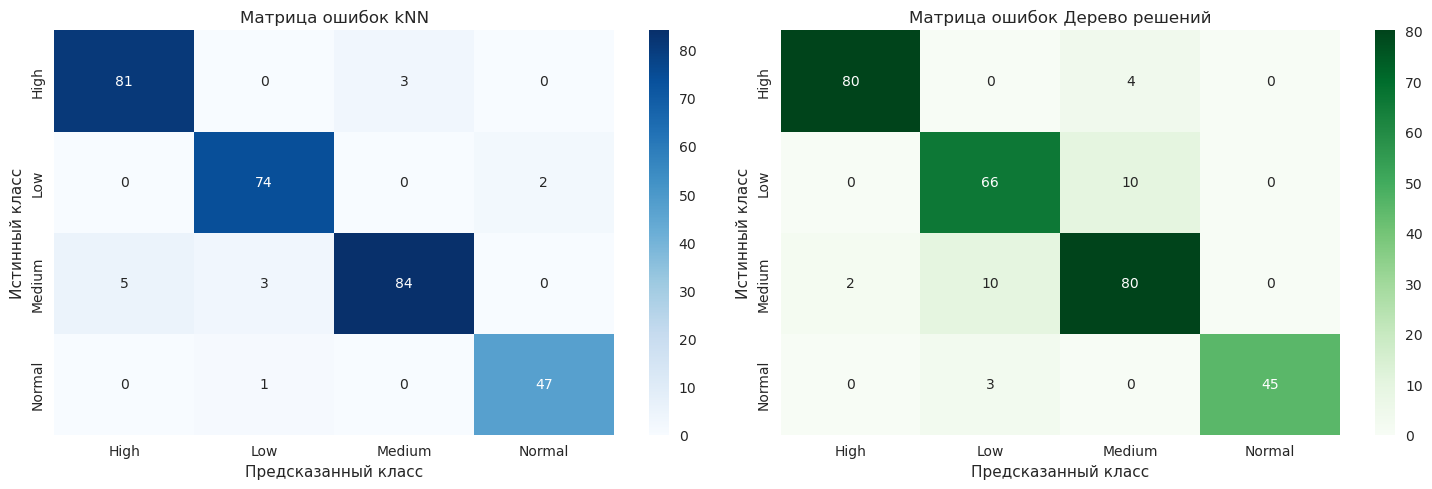

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=le.classes_, yticklabels=le.classes_)
ax1.set_title('Матрица ошибок kNN')
ax1.set_xlabel('Предсказанный класс')
ax1.set_ylabel('Истинный класс')

cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=le.classes_, yticklabels=le.classes_)
ax2.set_title('Матрица ошибок Дерево решений')
ax2.set_xlabel('Предсказанный класс')
ax2.set_ylabel('Истинный класс')

plt.tight_layout()
plt.show()

#### **ROC-кривые для двух алгоритмов классификации**

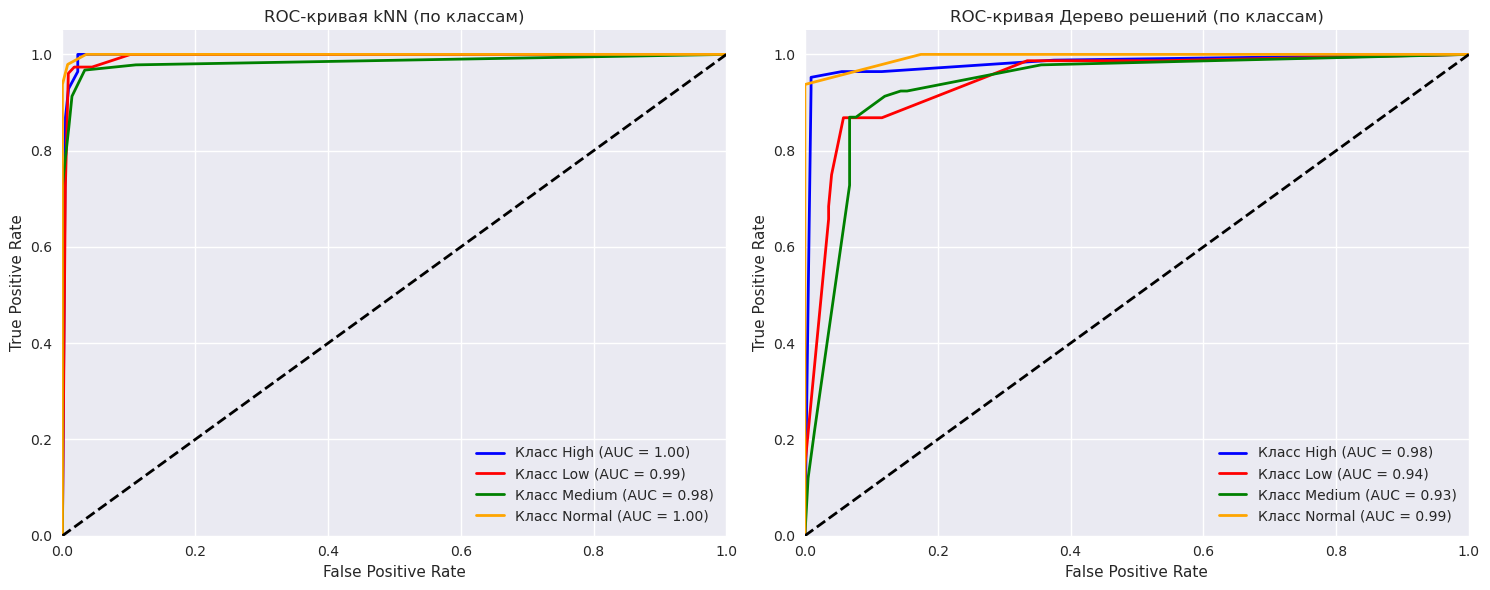

Макро-усредненный AUC kNN: 0.9636
Макро-усредненный AUC Дерево решений: 0.9636


In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC для kNN
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(le.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob_knn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Класс {0} (AUC = {1:0.2f})'.format(le.classes_[i], roc_auc[i]))

ax1.plot([0, 1], [0, 1], 'k--', lw=2)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC-кривая kNN (по классам)')
ax1.legend(loc="lower right")

# ROC для дерева решений
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob_dt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Класс {0} (AUC = {1:0.2f})'.format(le.classes_[i], roc_auc[i]))

ax2.plot([0, 1], [0, 1], 'k--', lw=2)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC-кривая Дерево решений (по классам)')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

macro_auc_knn = np.mean(list(roc_auc.values()))
macro_auc_dt = np.mean(list(roc_auc.values()))
print(f"Макро-усредненный AUC kNN: {macro_auc_knn:.4f}")
print(f"Макро-усредненный AUC Дерево решений: {macro_auc_dt:.4f}")

#### **Визуализация дерева решений**

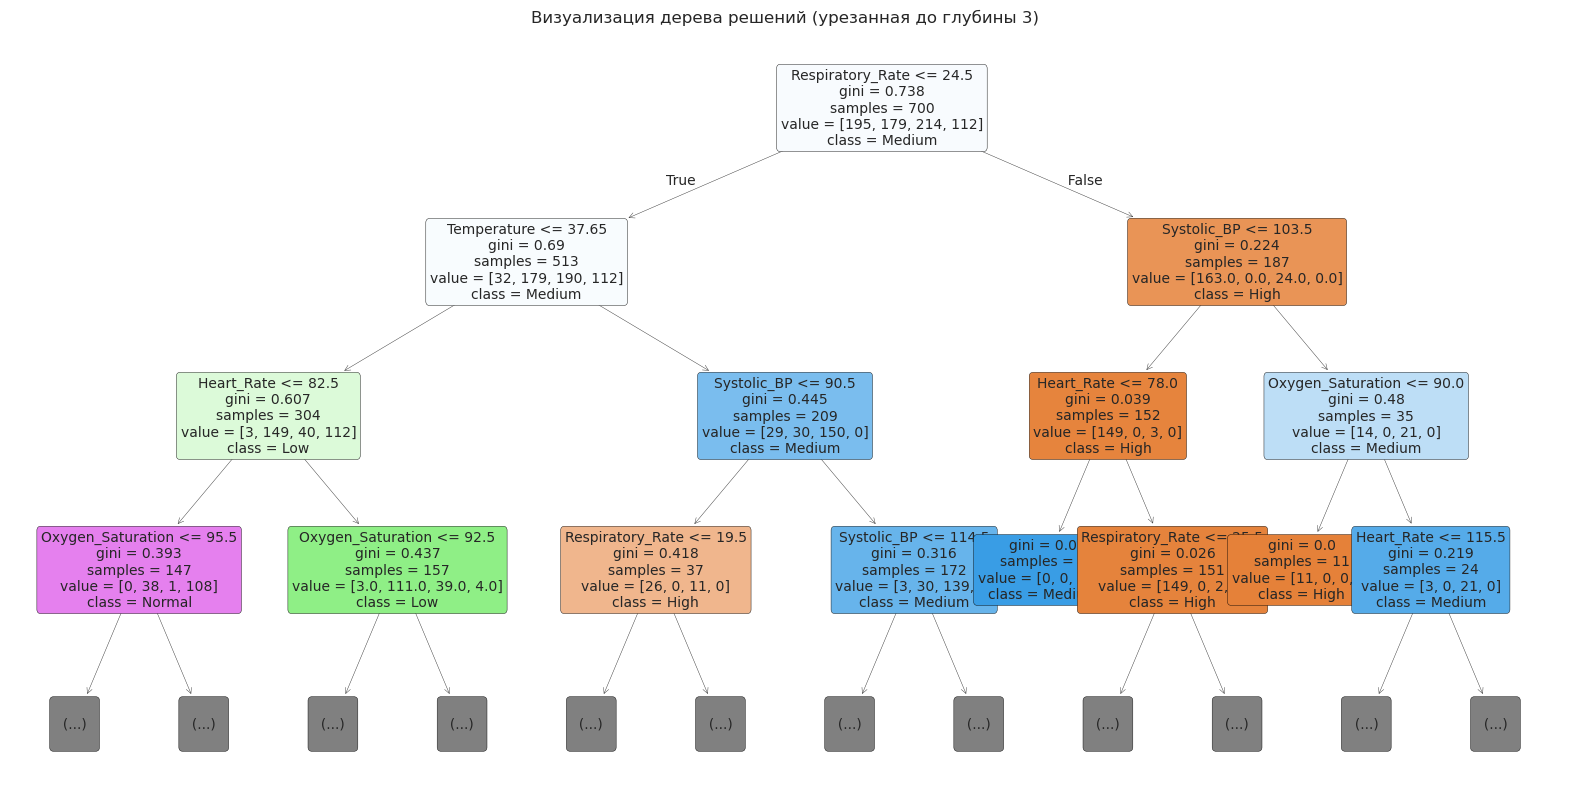

In [18]:
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X.columns, 
          class_names=le.classes_, rounded=True, max_depth=3, fontsize=10)
plt.title("Визуализация дерева решений (урезанная до глубины 3)")
plt.show()

#### **Кросс-валидация для двух алгоритмов классификации**

In [19]:
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Кросс-валидация kNN (точность): {knn_scores.mean():.3f} ± {knn_scores.std():.3f}")

dt_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')
print(f"Кросс-валидация Дерево решений (точность): {dt_scores.mean():.3f} ± {dt_scores.std():.3f}")

Кросс-валидация kNN (точность): 0.931 ± 0.007
Кросс-валидация Дерево решений (точность): 0.893 ± 0.027


#### **Важность признаков для дерева решений**

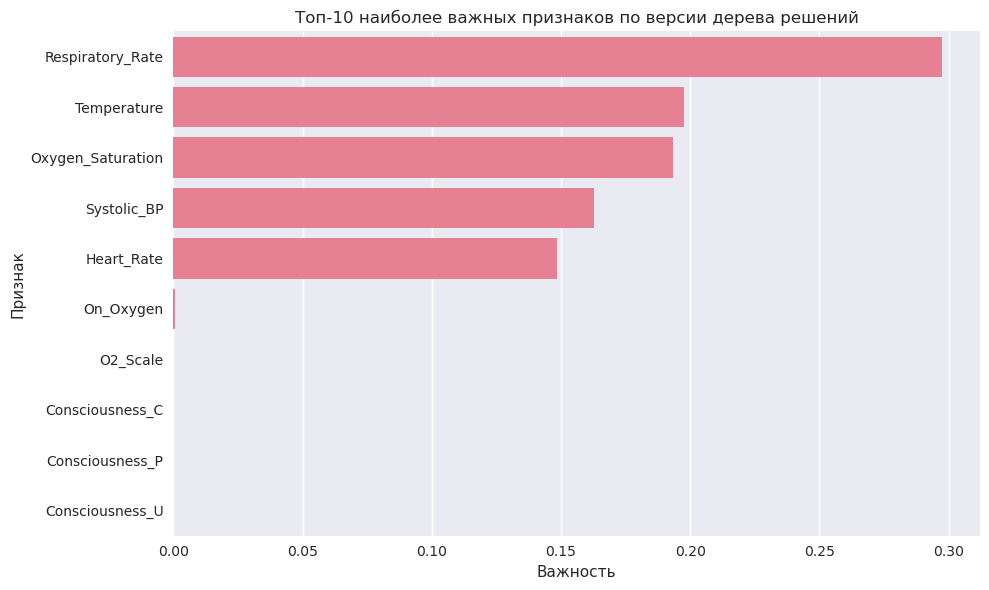

Важность признаков в дереве решений:
             Признак  Важность
0   Respiratory_Rate  0.297256
5        Temperature  0.197475
1  Oxygen_Saturation  0.193434
3        Systolic_BP  0.162678
4         Heart_Rate  0.148393
6          On_Oxygen  0.000765
2           O2_Scale  0.000000
7    Consciousness_C  0.000000
8    Consciousness_P  0.000000
9    Consciousness_U  0.000000


In [20]:
feature_importance = pd.DataFrame({
    'Признак': X.columns,
    'Важность': dt.feature_importances_
}).sort_values('Важность', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Важность', y='Признак', data=feature_importance.head(10))
plt.title('Топ-10 наиболее важных признаков по версии дерева решений')
plt.tight_layout()
plt.show()

print("Важность признаков в дереве решений:")
print(feature_importance.head(10))

#### **Сводная таблица метрик**

In [21]:
metrics_summary = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision (макро)', 'Recall (макро)', 'F1-score (макро)', 'AUC (макро)'],
    'kNN': [
        accuracy_score(y_test, y_pred_knn),
        classification_report(y_test, y_pred_knn, output_dict=True)['macro avg']['precision'],
        classification_report(y_test, y_pred_knn, output_dict=True)['macro avg']['recall'],
        classification_report(y_test, y_pred_knn, output_dict=True)['macro avg']['f1-score'],
        macro_auc_knn
    ],
    'Дерево решений': [
        accuracy_score(y_test, y_pred_dt),
        classification_report(y_test, y_pred_dt, output_dict=True)['macro avg']['precision'],
        classification_report(y_test, y_pred_dt, output_dict=True)['macro avg']['recall'],
        classification_report(y_test, y_pred_dt, output_dict=True)['macro avg']['f1-score'],
        macro_auc_dt
    ]
})

print("Сравнительная таблица метрик:")
metrics_summary

Сравнительная таблица метрик:


,Метрика,kNN,Дерево решений
0,Accuracy,0.953333,0.903333
1,Precision (макро),0.953820,0.915529
2,Recall (макро),0.957545,0.906967
3,F1-score (макро),0.955400,0.910856
4,AUC (макро),0.963618,0.963618


## **Вывод**

В ходе проделанной работы с медицинским датасетом были приобретены и применены важные навыки анализа данных и машинного обучения: освоены методы предобработки медицинских данных, включая преобразование категориальных признаков с использованием LabelEncoder и One-Hot Encoding, масштабирование числовых признаков с помощью StandardScaler для обеспечения корректной работы алгоритмов, основанных на вычислении расстояний. Были изучены и применены на практике два различных алгоритма классификации — k-ближайших соседей (kNN) и дерево решений, что позволило сравнить их эффективность для решения задачи прогнозирования уровня медицинского риска.

Проведенный анализ выявил высокую прогностическую способность обоих алгоритмов, с небольшим преимуществом метода kNN, достигшего точности 95.3%. Дерево решений, хотя и показало несколько меньшую точность (90.3%), предоставило ценную возможность интерпретации модели и выявления наиболее значимых диагностических признаков. Анализ важности признаков позволил определить ключевые показатели состояния пациентов: частоту дыхания, температуру тела, сатурацию кислорода, систолическое давление и частоту сердечных сокращений, что полностью соответствует медицинской практике.

Визуальный анализ результатов через матрицы ошибок и ROC-кривые подтвердил возможность эффективного автоматизированного прогнозирования состояния пациентов. Полученные модели могут быть использованы в системах поддержки врачебных решений для раннего выявления пациентов высокого риска, оптимизации распределения медицинских ресурсов и автоматической сортировки пациентов по степени срочности помощи.